# 0-D Reactors

Cantera can solve the coupled energy and species equations for zero-dimensional reactors. For further details of the actual equations that are solved, see the documentation: http://cantera.org/docs/sphinx/html/reactors.html The 0-D reactors have a number of options that enable them to model a wide range of systems, including user-controlled varying volume, heat transfer into or out of the environment, mass flow into and out of the system, and surface kinetics.

Effectively, there are two major choices the user must make in desiging the model of the basic system. The first is whether the reactor solves the general energy equation (solved in terms of the mixture enthalpy) or the ideal gas energy equation (solved in terms of the temperature). In general, the two methods will give the same solution to the problem; however, if the system can be modeled as an ideal gas, the ideal gas equation tends to be more robust and faster.

The second choice the user must make is whether the system will be modeled as constant pressure or constant volume.

For each of these choices, there is a specific reactor type:

* `Reactor`: Constant volume, general energy equation
* `IdealGasReactor`: Constant volume, ideal gas energy equation
* `ConstantPressureReactor`: Constant pressure, general energy equation
* `ConstantPressureIdealGasReactor`: Constant pressure, ideal gas energy equation

<div class="alert alert-block alert-info">

Old examples recommended that constant pressure reactors be approximated by allowing the volume of the reactor to expand very quickly as the reaction proceeded. This is no longer recommended because it creates extra stiffness in the solution and the `ConstantPressure...` reactors are a better solution

</div>

In the following example, we will solve a constant volume, adiabatic reactor problem, followed by a variable-volume reactor where the volume is controlled by a user-defined function.

In [1]:
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

The following experimental data comes from the work of Dames et al., *Combustion and Flame*, 168, 310-330, https://doi.org/10.1016/j.combustflame.2016.02.021 The experiment is a 50%-50% by mole mixture of propane and dimethyl ether. The experiment is a rapid compression machine experiment, where a compression process brings the reactant mixture to the end of compression (EOC) conditions. In this particular experiment, the EOC pressure is 30.11 bar and the EOC temperature is 682 K, and the ignition delay is 19.58 ms.

<IPython.core.display.Javascript object>


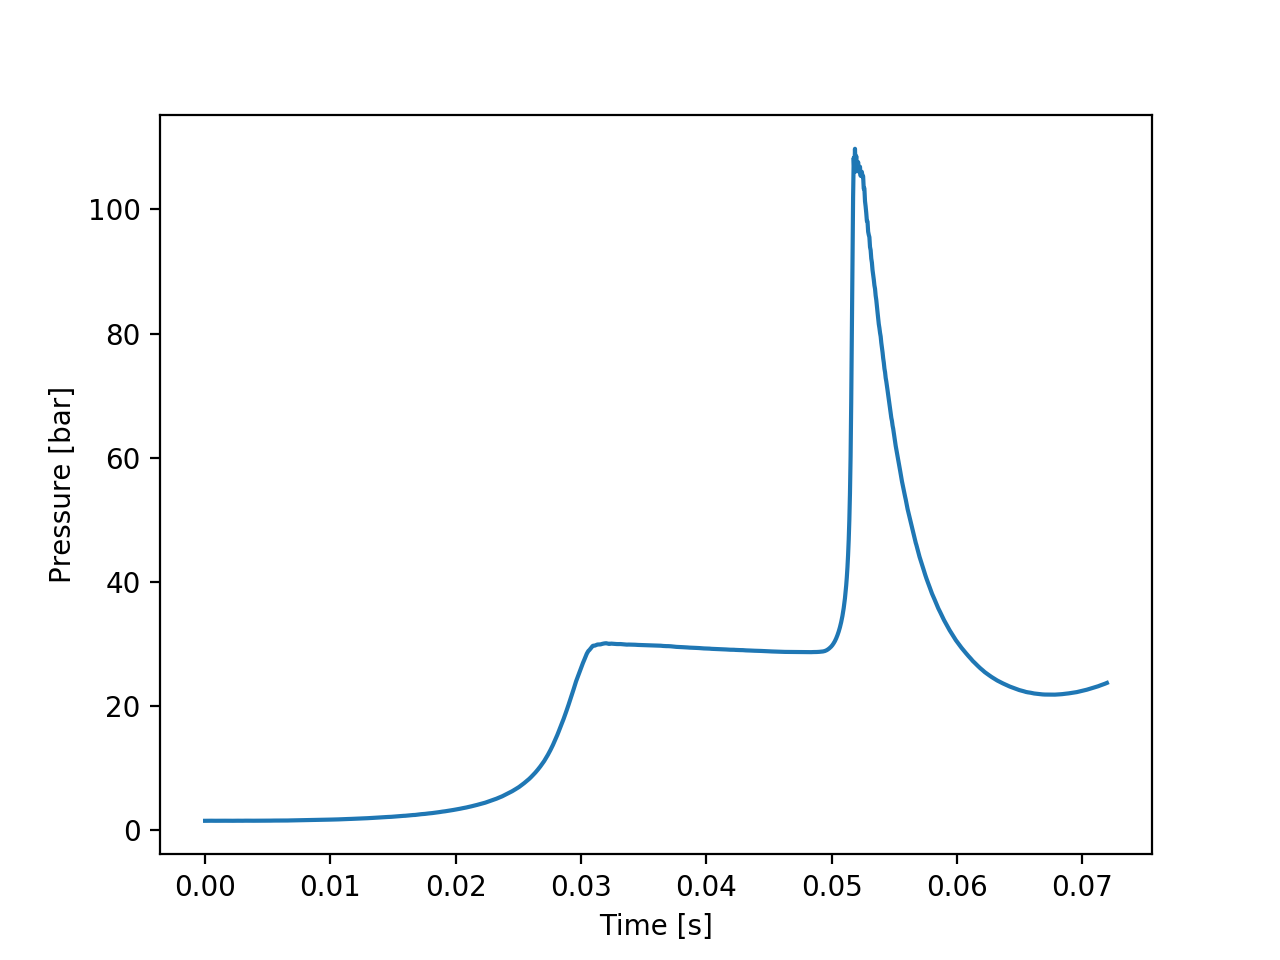

In [2]:
data = np.loadtxt('0d_example/Tc_682K_P0_1.5137_T0_323K_pressure.txt')
expt_time = data[:, 0]
expt_pres = data[:, 1]
plt.figure('Experimental Pressure')
plt.plot(expt_time, expt_pres)
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]');

In [4]:
gas = ct.Solution('0d_example/mech.cti')
gas.TP = 682, 30.11E5
gas.set_equivalence_ratio(1.0, {'ch3och3': 1, 'c3h8': 1}, {'o2': 1, 'n2': 3.76})

The experiment can be modeled as an ideal gas mixture, and the reactor can be modeled as constant volume for simplicity, with no mass transfer to/from the environment. The reactor is an `IdealGasReactor`, and after creating the reactor, we add it to a `ReactorNet`. The reactor network would also contain any flow controllers, if those were present.

In [5]:
reac = ct.IdealGasReactor(gas)
netw = ct.ReactorNet([reac])

The next step is to run the integrator. There are two options for this, the `advance` method of the `ReactorNet` and the `step` method. The `advance` method is useful when there is a desired end time for the integration, or you would like to have fixed step sizes in the output. The `step` method takes one variable sized time step, with the size determined by the integrator. It is useful when you want as much detail (in terms of time history) as possible. The easiest way to store the data is to append to `list`s.

In [6]:
temperature = []
pressure = []
volume = []
time = []

# End the simulation when the temperature exceeds 2500 K or the time reaches 0.1 s
while reac.T < 2500 and netw.time < 0.1:
    time.append(netw.time)
    temperature.append(reac.T)
    pressure.append(reac.thermo.P)
    volume.append(reac.volume)
    netw.step()

# It is more convenient to work with the data in NumPy arrays than Python lists, so convert
temperature = np.array(temperature)
pressure = np.array(pressure)
volume = np.array(volume)
time = np.array(time)

<IPython.core.display.Javascript object>


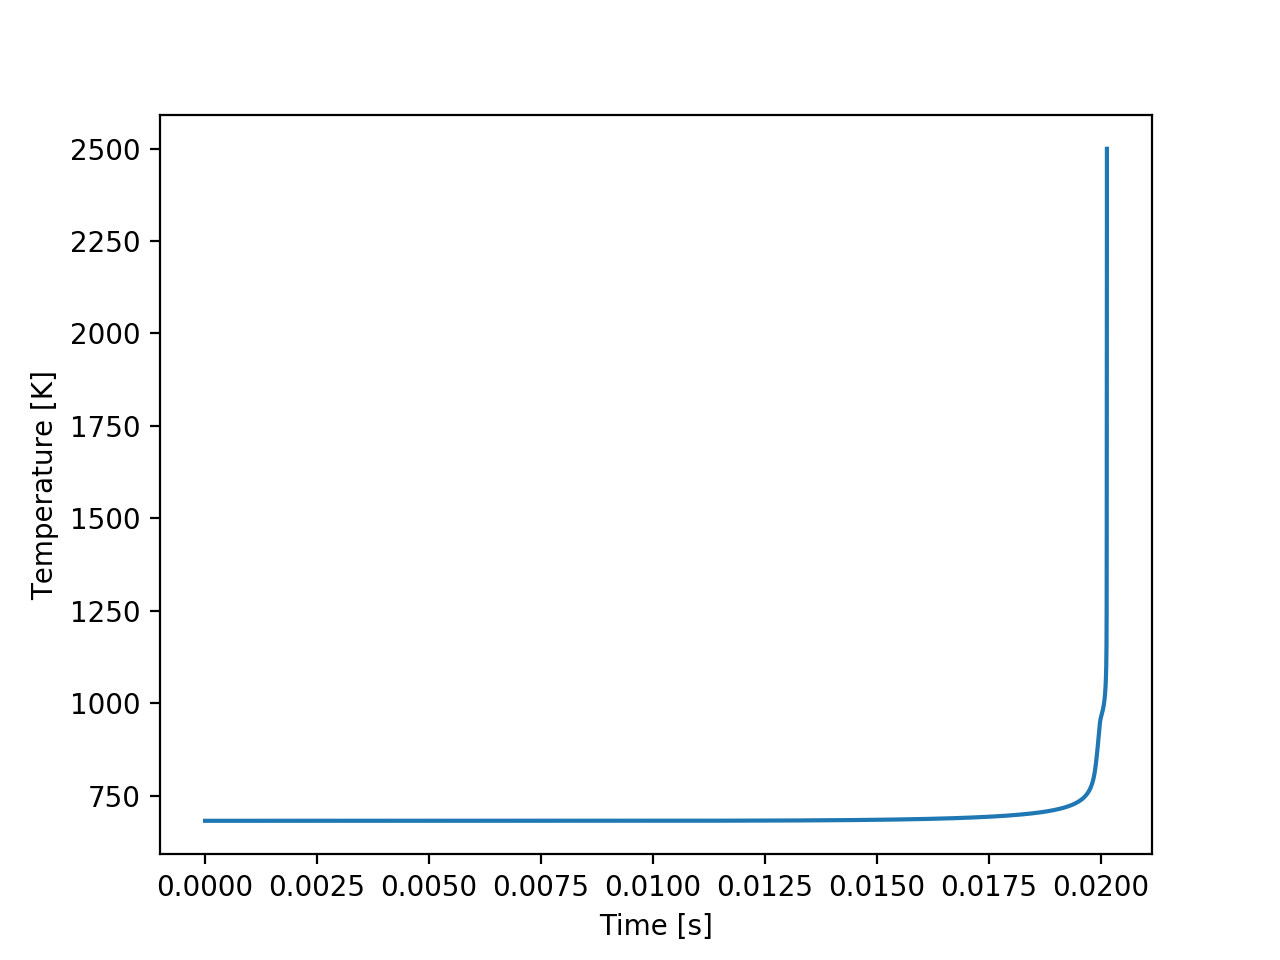

In [7]:
plt.figure('Simulated Temperature')
plt.plot(time, temperature)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]');

<IPython.core.display.Javascript object>


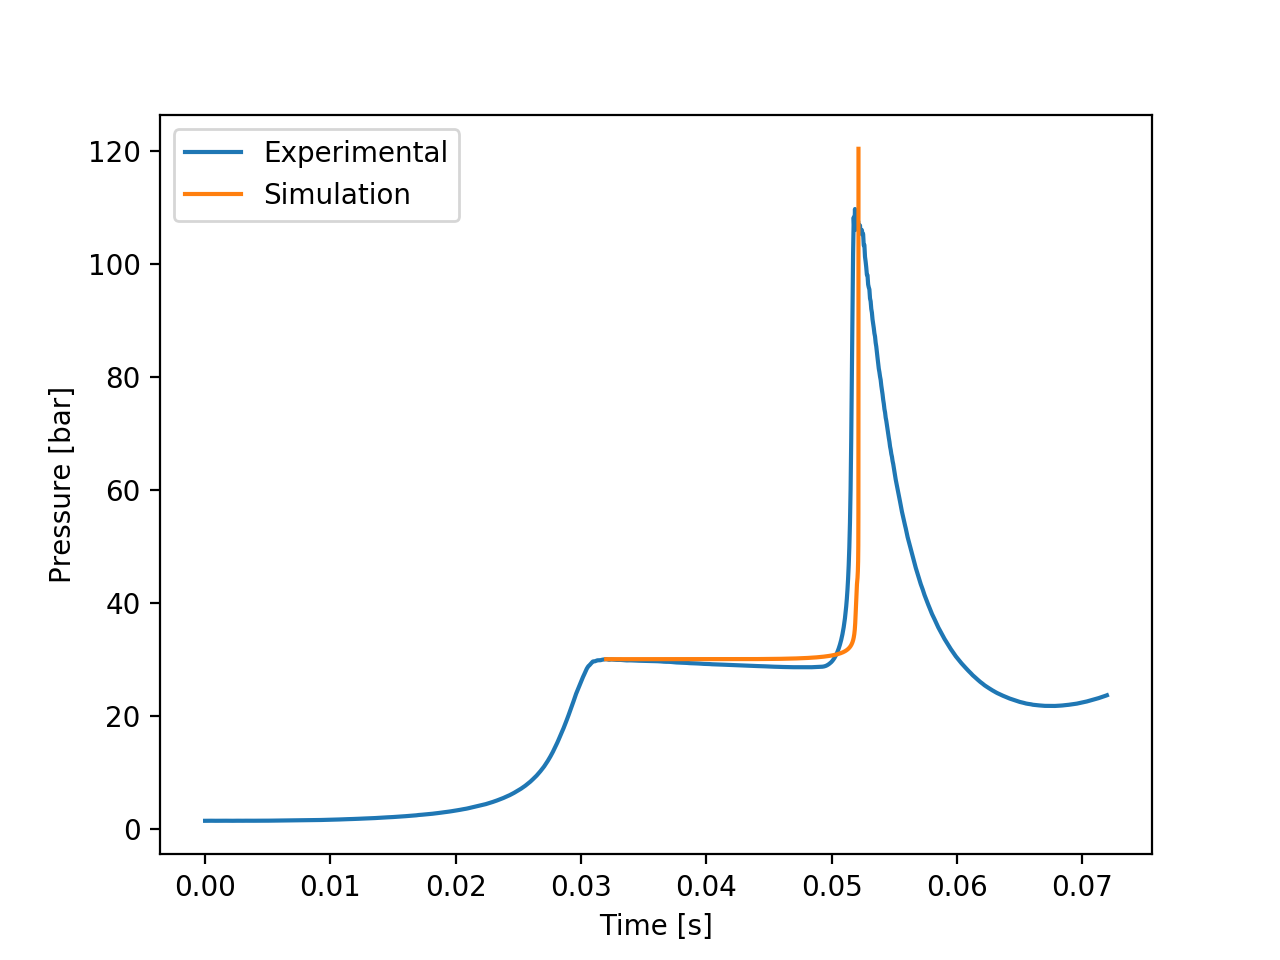

In [8]:
plt.figure('Experimental Pressure vs. Simulated Pressure')
plt.plot(expt_time, expt_pres, label='Experimental')
plt.plot(time + 0.032, pressure/1.0E5, label='Simulation')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]');

The agreement between the experiment and the model is quite good, although it is clear there is some experimental detail that is missing. We can account for this detail (the compression stroke and post-compression heat-loss) by changing the volume of the `IdealGasReactor` to model the processes in the experiment. The volume of the reactor can be changed by considering it as a piston-cylinder assembly. The area of the piston is constant, and the rate of change of the volume is the velocity of the piston. It is this velocity that must be specified to the reactor to change its volume. First, we will define a class with the special `__call__` that returns the velocity at a point in time. The time is passed as the argument to the `__call__` function.

In [9]:
class VolumeProfile(object):
    """
    Set the velocity of the piston by using a user specified volume
    profile. The initialization and calling of this class are handled
    by the `cantera.Func1` interface of Cantera.
    The velocity is calculated by assuming a unit area and using the
    forward difference, calculated by `numpy.diff`. This function is
    only called once when the class is initialized at the beginning of
    a problem so it is efficient.
    Parameters
    ----------
    time: `numpy.ndarray`
        Array or list of time values
    volume: `numpy.ndarray`
        Array or list of volume values
    Attributes
    ----------
    time: `numpy.ndarray`
        Array of time values
    volume: `numpy.ndarray`
        Array of volume values
    velocity: `numpy.ndarray`
        Array of velocity values
    """

    def __init__(self, time, volume):
        # The time and volume are stored as lists in the keywords
        # dictionary. The volume is normalized by the first volume
        # element so that a unit area can be used to calculate the
        # velocity.
        self.time = np.array(time)
        self.volume = np.array(volume)/volume[0]

        # The velocity is calculated by the forward difference.
        # numpy.diff returns an array one element smaller than the
        # input array, so we append a zero to match the length of the
        # self.time array.
        self.velocity = np.diff(self.volume)/np.diff(self.time)
        self.velocity = np.append(self.velocity, 0)

    def __call__(self, t):
        """Return the velocity when called during a time step.
        Parameters
        ----------
        t : `float`
            Current simulation time.
        """

        if t <= self.time[-1] and t >= self.time[0]:
            # prev_time_point is the previous value in the time array
            # after the current simulation time
            prev_time_point = self.time[self.time <= t][-1]
            # index is the index of the time array where
            # prev_time_point occurs
            index = np.where(self.time == prev_time_point)[0][0]
            return self.velocity[index]
        else:
            return 0

Now we need to define a `Solution` just like before.

In [10]:
gas = ct.Solution('0d_example/mech.cti')
gas.TP = 323, 1.5137E5
gas.set_equivalence_ratio(1.0, {'ch3och3': 1, 'c3h8': 1}, {'o2': 1, 'n2': 3.76})

The volume of the cylinder from the experiment is used to compute the velocity in the `VolumeProfile` class, so we need to load the volume trace from the file on the disk.

In [11]:
vol_data = np.loadtxt('0d_example/Tc_682K_P0_1.5137_T0_323K_volume.csv', delimiter=',')
inp_time = vol_data[:, 0]
inp_vol = vol_data[:, 1]

We can calculate a few values of velocity using the `VolumeProfile` class, just to demonstrate the operation. First, an instance of the class is initialized with the volume and time read from the input file. Then we can call the instance, passing time points, and the velocity is returned. If the time that is passed is greater than the maximum time present in the input file (0.4 s), the velocity returned is zero.

In [12]:
vpro = VolumeProfile(inp_time, inp_vol)
print(vpro(0.01))
print(vpro(0.35))
print(vpro(0.5))

-38.6576215208
0.388953308755
0


To effect the volume change, instances of `Wall`s can be installed between two Cantera reactors. In this case, we only care about reactions and changes in the reactor representing the RCM reaction chamber, so we install a `Wall` between the `IdealGasReactor` and a `Reservoir`, which represents the environment. Then we specify the `VolumeProfile` class as the means to calculate the velocity. Other options would be a constant value, or a function that takes a single argument (the simulation time). With the velocity defined and the `Wall` installed, the simulation can proceed as before.

In [13]:
reac = ct.IdealGasReactor(gas)
env = ct.Reservoir(ct.Solution('air.xml'))
wall = ct.Wall(reac, env, A=1.0, velocity=vpro)
netw = ct.ReactorNet([reac])
netw.set_max_time_step(inp_time[1])

vol_temperature = []
vol_pressure = []
vol_volume = []
vol_time = []

# End the simulation when the temperature exceeds 2500 K or the time reaches 0.1 s
while reac.T < 2500 and netw.time < 0.1:
    vol_time.append(netw.time)
    vol_temperature.append(reac.T)
    vol_pressure.append(reac.thermo.P)
    vol_volume.append(reac.volume)
    netw.step()

# It is more convenient to work with the data in NumPy arrays than Python lists, so convert
vol_temperature = np.array(vol_temperature)
vol_pressure = np.array(vol_pressure)
vol_volume = np.array(vol_volume)
vol_time = np.array(vol_time)

We can compare a number of parameters between the simulation and experiment. First, we can compare the volume that is read from the input file to the simulated volume of the reactor as a function of time. Remember that we did not specify the volume of the reactor directly, instead we specified it through the velocity. The two volume traces agree exactly (although the simulated volume is somewhat shorter than the input volume because of the conditions we placed on the integration).

<IPython.core.display.Javascript object>


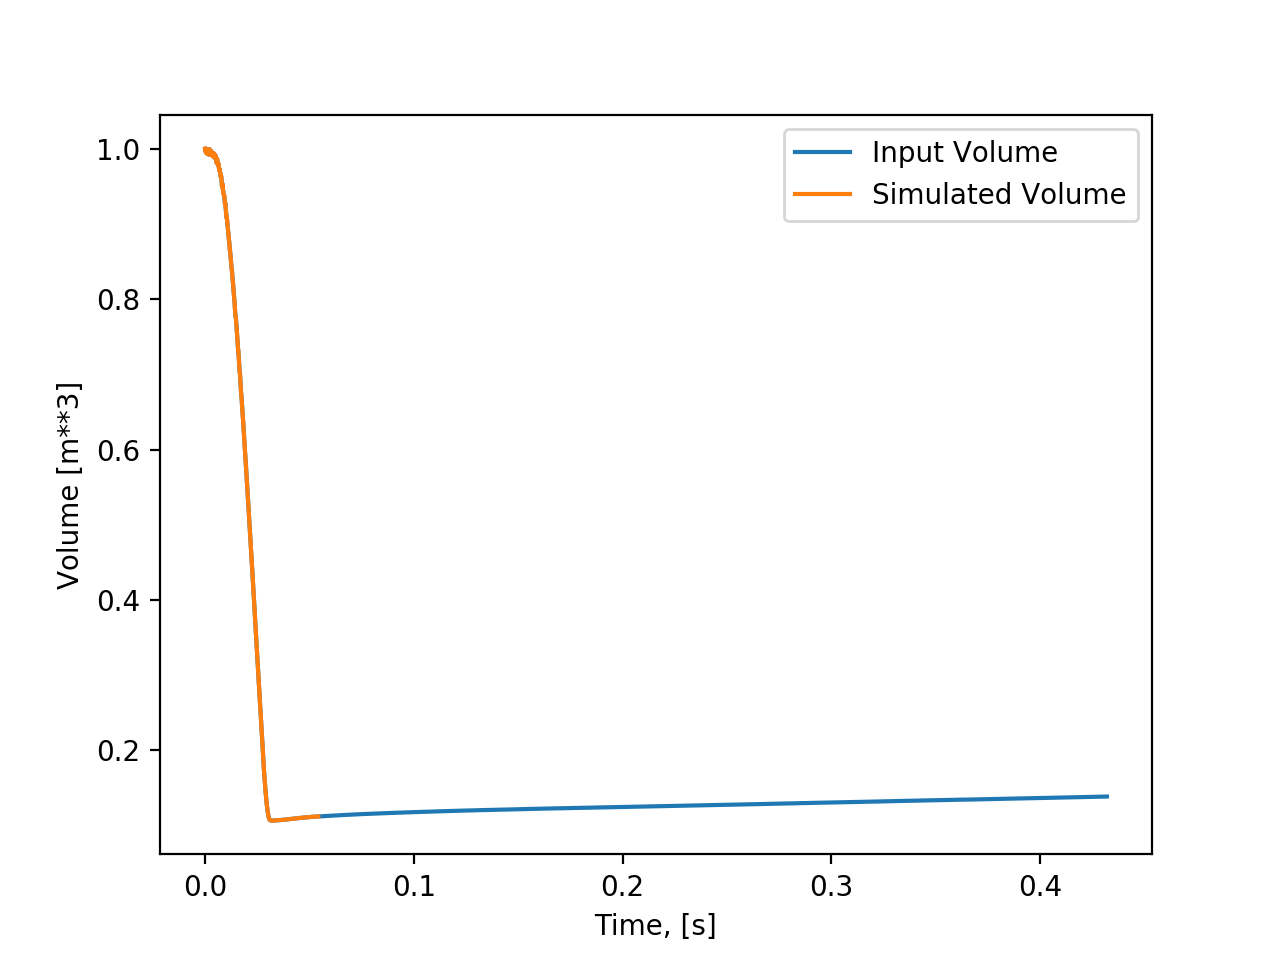

In [14]:
plt.figure('Volume Trace Comparison')
plt.plot(inp_time, inp_vol, label='Input Volume')
plt.plot(vol_time, vol_volume, label='Simulated Volume')
plt.ylabel('Volume [m**3]')
plt.xlabel('Time, [s]')
plt.legend();

<IPython.core.display.Javascript object>


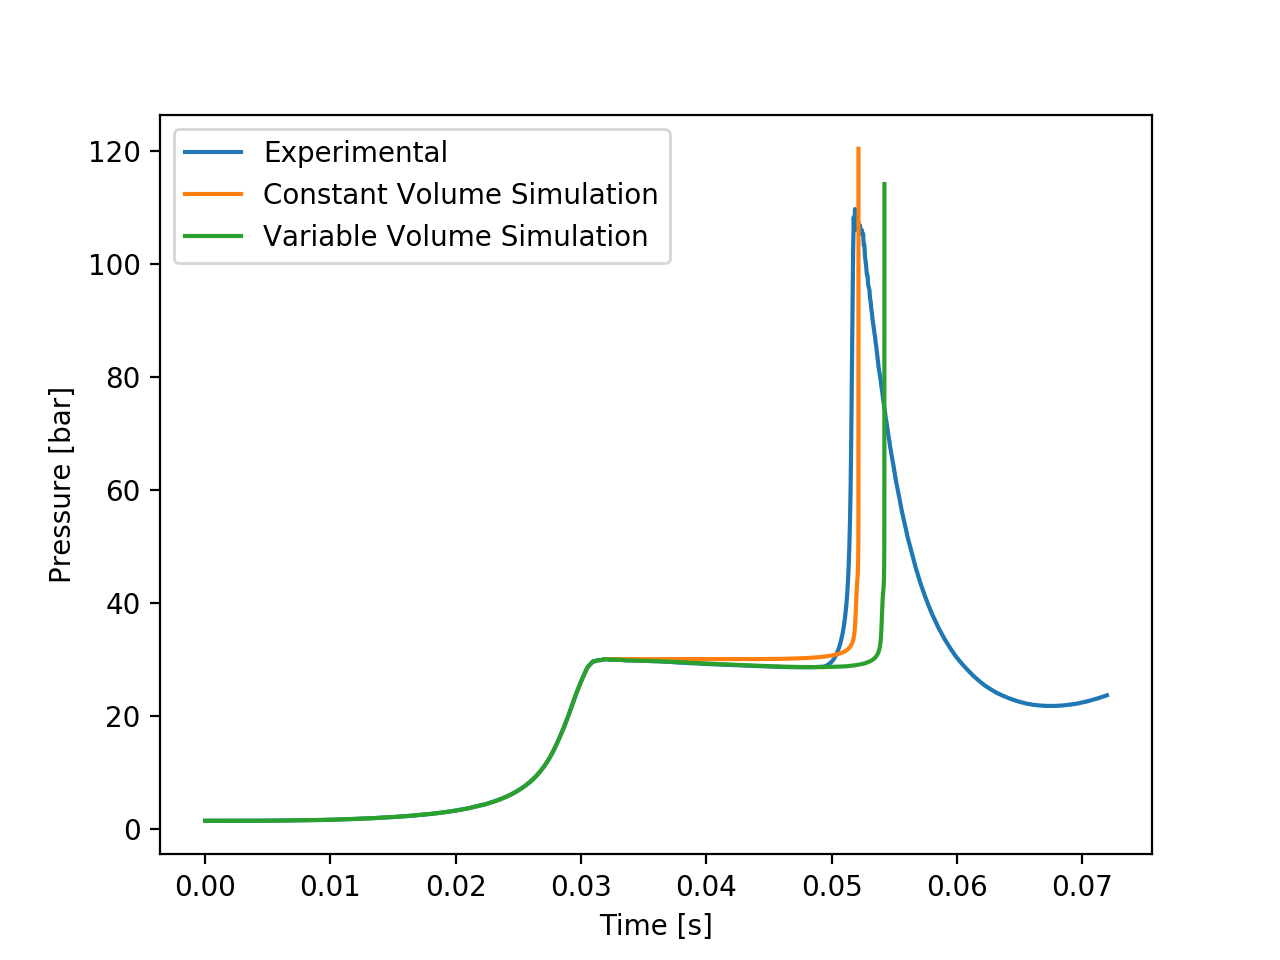

In [15]:
plt.figure('Experimental Pressure vs. Simulated Pressure 2')
plt.plot(expt_time, expt_pres, label='Experimental')
plt.plot(time + 0.032, pressure/1.0E5, label='Constant Volume Simulation')
plt.plot(vol_time, vol_pressure/1.0E5, label='Variable Volume Simulation')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]');

Then, comparing all three pressure traces, we can see that the green variable volume simulation very closely approximates the behavior of the experimental pressure trace, including the compression stroke and post-compression behavior. User defined functions and classes, such as the one used to compute the velocity of the wall in this example, are very powerful in Cantera. Another example where they are very useful is to construct a perfectly stirred reactor model with fixed residence time, rather than fixed mass flow rate (https://groups.google.com/d/msg/cantera-users/dMUhi5kVVDk/bDFYWMQsgbAJ).

In [16]:
gas = ct.Solution('h2o2.xml')

gas.TPX = 300, ct.one_atm, 'H2:1.0, O2:2.0, AR:4.0'
upstream = ct.Reservoir(gas)
downstream = ct.Reservoir(gas)

gas.equilibrate('HP')
r1 = ct.IdealGasReactor(gas)

residence_time = 1e-4

def mdot_out(t):
    return r1.mass / residence_time

inlet = ct.Valve(upstream, r1, K=100)
outlet = ct.MassFlowController(r1, downstream)
outlet.set_mass_flow_rate(mdot_out)

net = ct.ReactorNet([r1])

t = np.linspace(0, 5*residence_time, 200)
T = np.zeros(t.shape)
mdot = np.zeros(t.shape)
for i,ti in enumerate(t):
    if ti:
        net.advance(ti)
    T[i] = r1.T
    mdot[i] = outlet.mdot(ti)

<IPython.core.display.Javascript object>


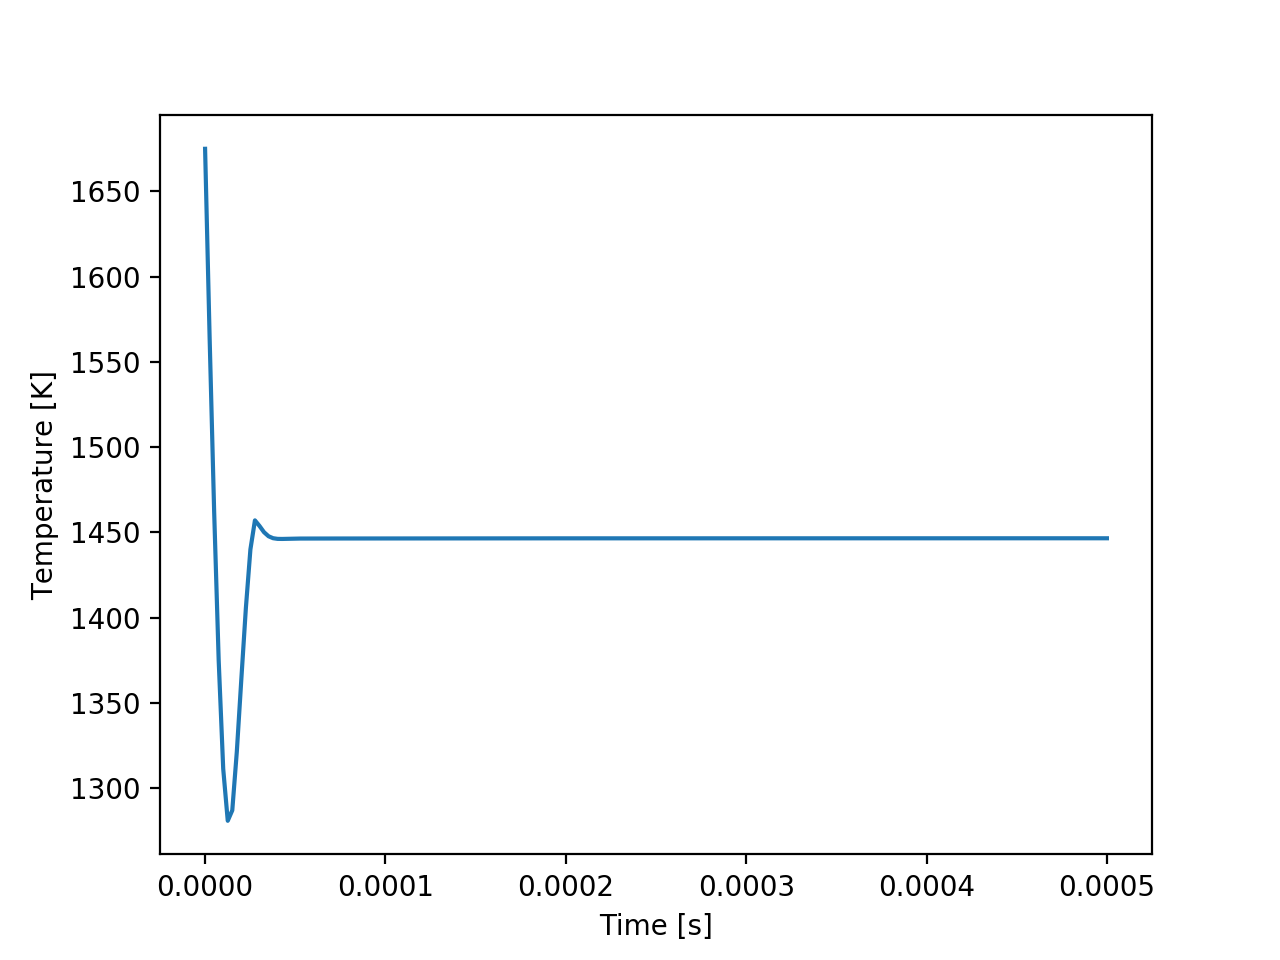

In [17]:
plt.figure('PSR Time vs. Temperature')
plt.plot(t, T)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]');

<IPython.core.display.Javascript object>


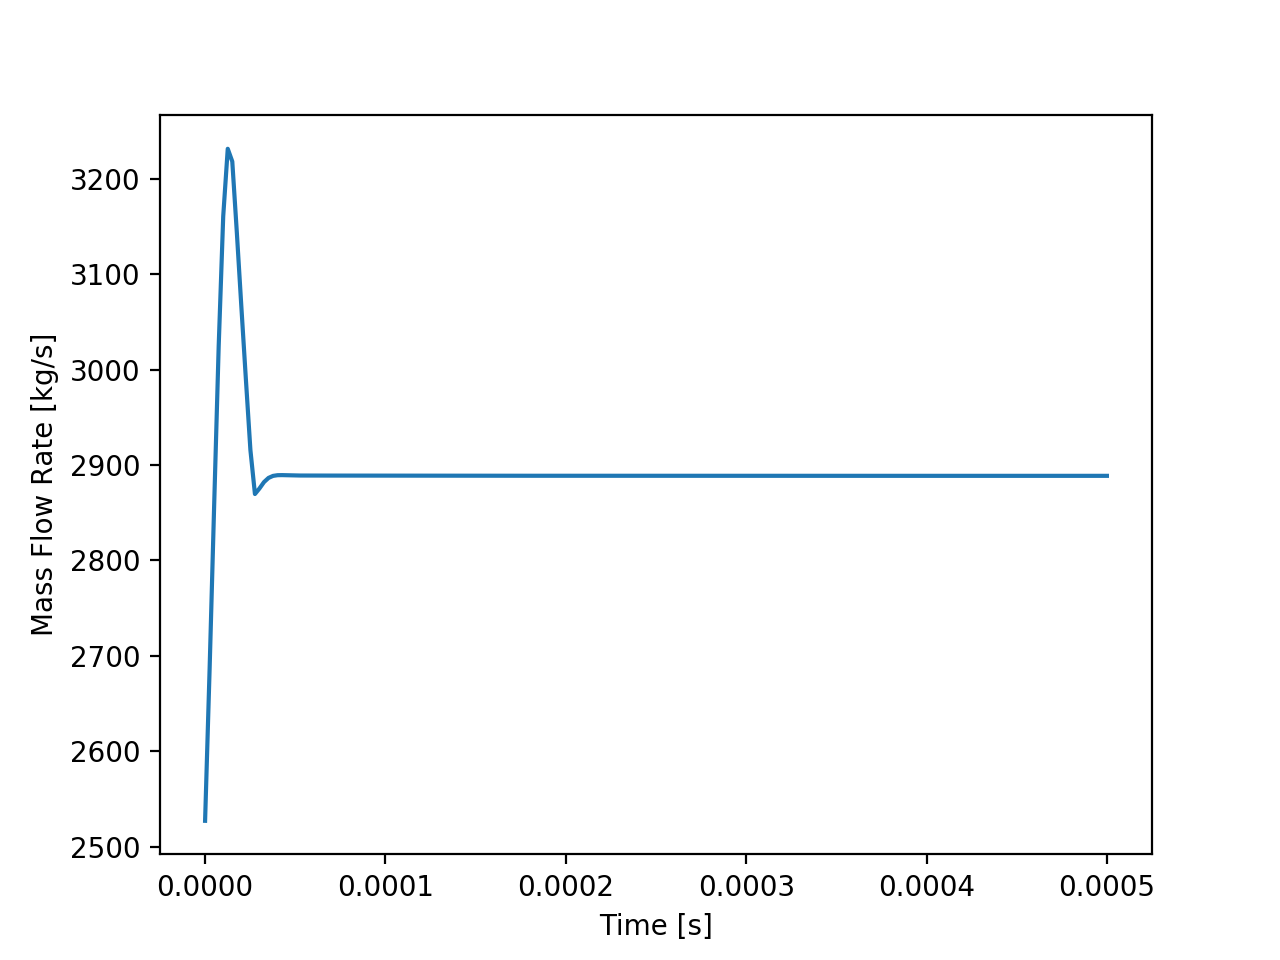

In [18]:
plt.figure('PSR Time vs. Mass Flow Rate')
plt.plot(t, mdot)
plt.xlabel('Time [s]')
plt.ylabel('Mass Flow Rate [kg/s]');